In [1]:
import pandas as pd
import lightgbm as lgb
from datetime import datetime
import matplotlib.pyplot as plt
import json
import numpy as np

import warnings
warnings.filterwarnings('ignore')

fase = '05_lightgbm (un intento)'

In [2]:
with open('gen_config.json', 'r') as file:
    gen_config =json.load(file)

In [3]:
folder = gen_config['folder']

path_pred_test = gen_config['path_pred_test']
path_pred_futuro = gen_config['path_pred_futuro']
path_prod_stats = gen_config['path_prod_stats']

path_train = gen_config['path_train']
path_test = gen_config['path_test']
path_futuro = gen_config['path_futuro']

lgbm_params = gen_config['var_lgbm_params']
exclusiones = gen_config['var_exclusiones']
dibujar_pesos = gen_config['var_dibujar_pesos']

print(f"{'COMIENZA':-^100}")
print(f"{fase:-^100}")

----------------------------------------------COMIENZA----------------------------------------------
--------------------------------------05_lightgbm (un intento)--------------------------------------


In [4]:
df_train = pd.read_parquet(f"{folder}/{path_train}")
df_test = pd.read_parquet(f"{folder}/{path_test}")
df_futuro = pd.read_parquet(f"{folder}/{path_futuro}")

print(f"{'Shape df_train':.<25}: {df_train.shape}")
print(f"{'Shape df_test':.<25}: {df_test.shape}")
print(f"{'Shape df_futuro':.<25}: {df_futuro.shape}")

Shape df_train...........: (13790, 187)
Shape df_test............: (542, 187)
Shape df_futuro..........: (542, 187)


In [5]:
categorical_features = df_train.select_dtypes(['category']).columns.tolist()
for col in categorical_features:
    print(f"Convertida {col} a Categorical")
    df_train[col] = df_train[col].cat.codes
    df_test[col] = df_test[col].cat.codes
    df_futuro[col] = df_futuro[col].cat.codes

Convertida yearquarter a Categorical
Convertida cat1 a Categorical
Convertida cat2 a Categorical
Convertida cat3 a Categorical
Convertida brand a Categorical
Convertida descripcion a Categorical


In [6]:
X_train = df_train.iloc[:,:-1]
X_test = df_test.iloc[:,:-1]
X_futuro = df_futuro.iloc[:,:-1]

y_train = df_train.iloc[:,-1]
y_test = df_test.iloc[:,-1]
y_futuro = df_futuro.iloc[:,-1]

print(f"{'Shape X_train':.<25}: {X_train.shape}")
print(f"{'Shape X_test':.<25}: {X_test.shape}")
print(f"{'Shape X_futuro':.<25}: {X_futuro.shape}")

print(f"{'Shape y_train':.<25}: {y_train.shape}")
print(f"{'Shape y_test':.<25}: {y_test.shape}")
print(f"{'Shape y_futuro':.<25}: {y_futuro.shape}")

Shape X_train............: (13790, 186)
Shape X_test.............: (542, 186)
Shape X_futuro...........: (542, 186)
Shape y_train............: (13790,)
Shape y_test.............: (542,)
Shape y_futuro...........: (542,)


In [8]:
train_data = lgb.Dataset(X_train.drop(columns=exclusiones), label=y_train)
test_data = lgb.Dataset(X_test.drop(columns=exclusiones), label=y_test)
futuro_data = lgb.Dataset(X_futuro.drop(columns=exclusiones), label=y_futuro)

params = lgbm_params

model = lgb.train(params,
                train_data,
                num_boost_round=1000,
                valid_sets=[train_data, test_data],
                )

#y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = model.predict(X_test.drop(columns=['group_index','periodo', 'periodo_dt']), num_iteration=model.best_iteration)
y_pred_futuro = model.predict(X_futuro.drop(columns=['group_index','periodo', 'periodo_dt']), num_iteration=model.best_iteration)

#example_row = X_test.iloc[0]
#example_pred = model.predict(example_row.values.reshape(1, -1), num_iteration=model.best_iteration)
#print(f'Prediction for example row: {example_pred[0]}')

[LightGBM] [Info] Total Bins 101081
[LightGBM] [Info] Number of data points in the train set: 13790, number of used features: 177
[LightGBM] [Info] Start training from score -0.032569


In [ ]:
final = X_test
final['tn_futuro'] = y_test
final['tn_prediccion'] = y_pred

In [ ]:
#prod_stats = pd.read_parquet('prod_stats.parquet')
prod_stats = pd.read_parquet(f"{folder}/{path_prod_stats}")
#prod_stats = pd.read_parquet('./Experimentos/2024-06-23_NuevoScript/01_prod_stats.parquet')

prod_stats = prod_stats[['group_index', 'average_tn','std_dev_tn']]
final = final.merge(prod_stats, how='left', on='group_index')
final.columns

Index(['group_index', 'periodo', 'primer_periodo', 'ultimo_periodo', 'tn_norm',
       'periodo_dt', 'mes', 'quarter', 'month_in_quarter', 'year',
       ...
       'prop_product_yearquarter_brand',
       'prop_product_yearquarter_descripcion', 'prop_product_year_cat1',
       'prop_product_year_cat2', 'prop_product_year_brand',
       'prop_product_year_descripcion', 'tn_futuro', 'tn_prediccion',
       'average_tn', 'std_dev_tn'],
      dtype='object', length=190)

In [ ]:
final['tn_futuro_real'] = (final['tn_norm'] + final['tn_futuro']) * final['std_dev_tn'] + final['average_tn'] # por dos porque esta normalizado y al hacer sumas y restas se acumulan medias
final['tn_prediccion_real'] = (final['tn_norm'] + final['tn_prediccion']) * final['std_dev_tn'] + final['average_tn']

In [ ]:
final.head()

,group_index,periodo,primer_periodo,ultimo_periodo,tn_norm,periodo_dt,mes,quarter,month_in_quarter,year,...,prop_product_year_cat1,prop_product_year_cat2,prop_product_year_brand,prop_product_year_descripcion,tn_futuro,tn_prediccion,average_tn,std_dev_tn,tn_futuro_real,tn_prediccion_real
0,0,201910,201701,201912,-0.676253,201910,10,4,1,2019,...,0.006340,0.008434,0.011276,8.870095,-1.859492,-0.492193,5.961235,2.164849,0.47173,3.431727
1,1,201910,201701,201912,1.416488,201910,10,4,1,2019,...,0.102352,0.136158,0.182033,10.292274,-0.870918,-1.457715,45.055592,19.446381,55.66495,44.253865
2,3,201910,201701,201912,0.907566,201910,10,4,1,2019,...,0.040285,0.053590,1.019582,2.945124,-2.000504,-1.159309,20.425481,8.979435,10.61151,18.164972
3,4,201910,201701,201912,2.434911,201910,10,4,1,2019,...,0.133150,0.177129,1.625048,9.734356,-2.291788,-2.100430,52.564027,17.201064,55.02588,58.317451
4,8,201910,201701,201912,0.520914,201910,10,4,1,2019,...,0.690645,0.918759,1.228310,11.038848,-2.562506,-1.567344,423.968669,126.554825,165.59536,291.537923


In [ ]:
#final.to_parquet('sell_in_pred.parquet', index=False)
final.to_parquet(f'{folder}/{path_pred_test}', index=False)

In [ ]:
final_futuro = X_futuro
final_futuro['tn_futuro'] = y_futuro
final_futuro['tn_prediccion'] = y_pred_futuro

final_futuro = final_futuro.merge(prod_stats, how='left', on='group_index')
final_futuro.columns

# por dos porque esta normalizado y al hacer sumas y restas se acumulan medias
final_futuro['tn_futuro_real'] = (final_futuro['tn_norm'] + final_futuro['tn_futuro']) * final_futuro['std_dev_tn'] + final_futuro['average_tn'] 
final_futuro['tn_prediccion_real'] = (final_futuro['tn_norm'] + final_futuro['tn_prediccion']) * final_futuro['std_dev_tn'] + final_futuro['average_tn']

#final_futuro.to_parquet('sell_in_pred_futuro.parquet', index=False)
final_futuro.to_parquet(f'{folder}/{path_pred_futuro}', index=False)

In [ ]:
#estado_control = f"05_lightgbm Terminado - {nombrefile} - {datetime.now()}"

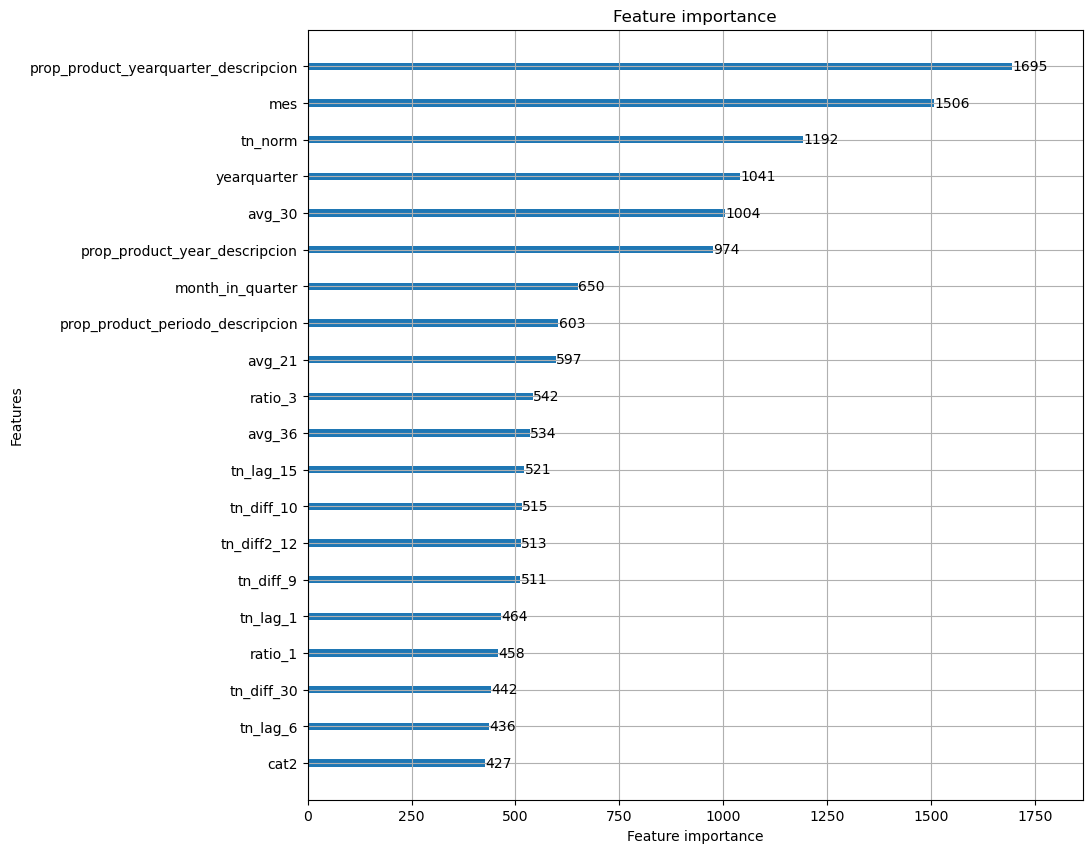

In [ ]:
lgb.plot_importance(model, max_num_features=20, figsize=(10,10))
plt.show()

In [ ]:
importance_df = (
    pd.DataFrame({
        'feature_name': model.feature_name(),
        'importance_gain': model.feature_importance(importance_type='gain'),
        'importance_split': model.feature_importance(importance_type='split'),
    })
    .sort_values('importance_gain', ascending=False)
    .reset_index(drop=True)
)
importance_df.sort_values('importance_split', ascending=False, inplace=True)
feat_dibujar = importance_df[0:20]['feature_name'].reset_index(drop=True)

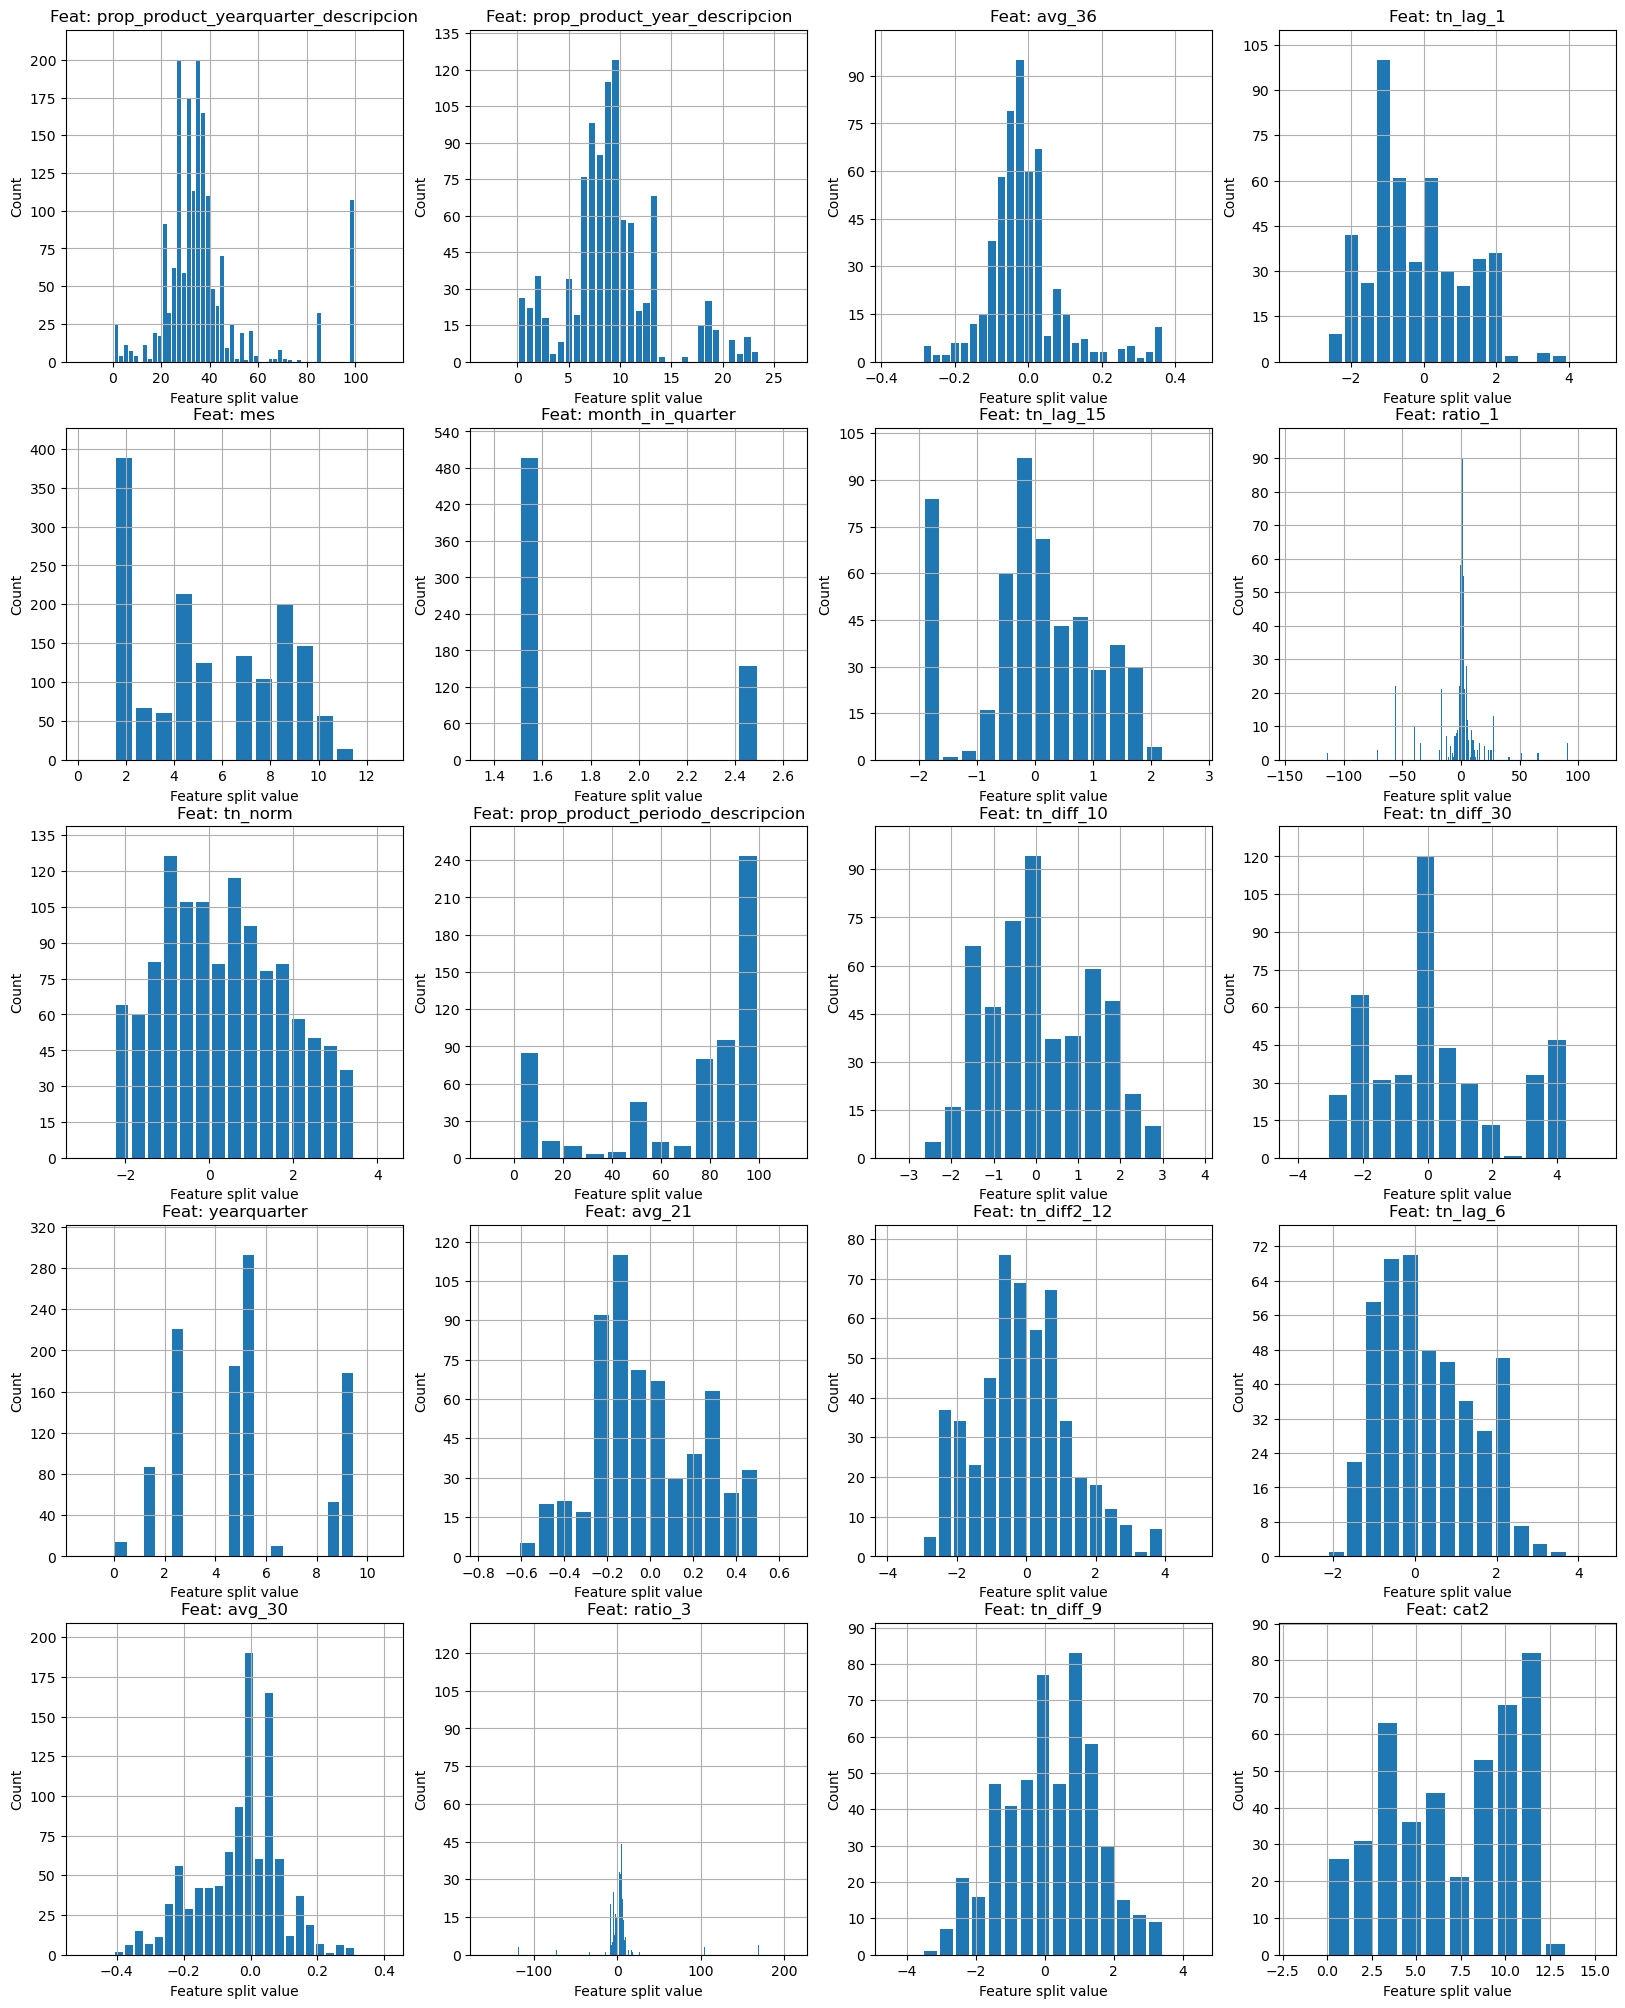

In [ ]:
if dibujar_pesos==True:
    fig, axs = plt.subplots(5, 4, figsize=(20, 25))
    d = -1
    for i in range(4):
        for j in range(5):
            d+=1
            lgb.plot_split_value_histogram(model,
                            feature=feat_dibujar[d],
                            bins="auto",
                            ax=axs[j, i]
                            ,title=f"Feat: {feat_dibujar[d]}")
    plt.show()

In [ ]:
print(f"{fase:-^100}")
print(f"{'FINALIZA':-^100}\n")

--------------------------------------05_lightgbm (un intento)--------------------------------------
----------------------------------------------FINALIZA----------------------------------------------

